In [1]:
%load_ext autoreload
%autoreload 2
import load_prism
import load_tether
import torch
import yaml
import logging
import matplotlib.pyplot as plt
from liftpose.vision_3d import *
from liftpose.preprocess import concat_dict, total_frames, center_poses, anchor_to_root, flatten_dict, unflatten_dict
from liftpose.plot import plot_pose_3d, plot_pose_2d
from tqdm import tqdm
tqdm.get_lock().locks = []

# Load data in the source domain (tethered fly) and rotate it to ventral camera angle

In [3]:
# declare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/domain_adaptation/data_DF3D_prism', # change the path 
              #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/domain_adaptation',
               'train_subjects' : ['Fly1','Fly2'],
               'actions'        : ['all']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par_source = {**par_data["data"], **par_train}

# Load 3D data
pts3d_source = load_tether.load_3D(
    par_source["data_dir"],
    par_source,
    subjects=par_source["train_subjects"],
    actions=par_source["actions"],
)

#center
pts3d_source = center_poses(pts3d_source)

#concatenate dicts of experiments
pts3d_source = concat_dict(pts3d_source)

#project to ventral view
intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480) 
tvec = np.array([0, 0, 117])
pts2d_source = project_to_eangle(pts3d_source, [-90,0,0], axsorder='xzy', project=True, tvec=tvec, intr=intr)
pts3d_source = project_to_eangle(pts3d_source, [-90,0,0], axsorder='xzy')


# Load data in the target domain (fly in prism-mirror setup)

In [10]:
# declare data parameters
par_train = {'data_dir'       : "/data/LiftPose3D/domain_adaptation/data_DF3D_prism/", # change the path
             'out_dir'        : '/data/LiftPose3D/domain_adaptation',
             "train_subjects" : ['Flyprism1','Flyprism2'],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
pts3d_target, keypts_target, _ = load_prism.load_3D(par["data_dir"], 
                                            subjects=par['train_subjects'], 
                                            actions=par['actions'])

#center
pts3d_target = center_poses(pts3d_target)

#concatenate dicts of experiments
pts3d_target = concat_dict(pts3d_target)
keypts_target = concat_dict(keypts_target)

#project data to ventral view
pts2d_target = XY_coord_dict(pts3d_target)

pts2d_target = pts2d_target['']

ind = [i for i in range(2000,6000)]
#ind = [i for i in range(0,500)]
pts2d_target = pts2d_target[ind]
pts3d_target = pts3d_target[ind]
keypts_target = keypts_target[ind]

# Find nearest neighbours

In [49]:
pts2d_source = torch.load('test_2d_DF3D.pth.tar')
pts2d_target = torch.load('test_2d_prism.pth.tar')
pts3d_source = torch.load('test_3d_DF3D.pth.tar')
pts3d_target, keypts_target = torch.load('test_3d_prism.pth.tar')

pts2d_source = np.concatenate([v for k,v in pts2d_source.items()], 0)
pts2d_target = np.concatenate([v for k,v in pts2d_target.items()], 0)
pts3d_source = np.concatenate([v for k,v in pts3d_source.items()], 0)
pts3d_target = np.concatenate([v for k,v in pts3d_target.items()], 0)
keypts_target = np.concatenate([v for k,v in keypts_target.items()], 0)

pts2d_source = pts2d_source.reshape(pts2d_source.shape[0],pts2d_source.shape[1]//2, 2)
pts2d_target = pts2d_target.reshape(pts2d_target.shape[0],pts2d_target.shape[1]//2, 2)
pts3d_source = pts3d_source.reshape(pts3d_source.shape[0],pts3d_source.shape[1]//3, 3)
pts3d_target = pts3d_target.reshape(pts3d_target.shape[0],pts3d_target.shape[1]//3, 3)
keypts_target = np.tile(keypts_target[:,:,None],3)

pts3d_source = project_to_eangle(pts3d_source, [-90,0,0], axsorder='xzy')

In [51]:
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle

nn = 20
frac_samples = 0.05

try:
    poses, nns_2d, nns_3d = pickle.load(open(par_train['out_dir']+'/neighbors.pkl','rb'))
    print('loaded existing neighbor data')

except:
    total = pts3d_target.shape[0]
    poses = [i for i in range(int(frac_samples*total))]
    #poses = np.random.choice([i for i in range(total)], size=int(frac_samples*total), replace=False)

    #3D poses
    nns_3d = process_map(partial(find_neighbours, 
                         pts=pts3d_source, 
                         target_pts=pts3d_target, 
                         nn=nn),
                         #good_keypts=keypts_target), 
                  poses, max_workers=16)
                         
    #2D poses
    nns_2d = process_map(partial(find_neighbours, 
                         pts=pts2d_source,
                         target_pts=pts2d_target, 
                         nn=nn), 
                  poses, max_workers=16)

    pickle.dump([poses, nns_2d,nns_3d],open(par_train['out_dir']+'/neighbors.pkl','wb'))
    


  0%|          | 0/588 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

Check how much data is needed to generalize

Text(0.5, 0, 'Number of poses')

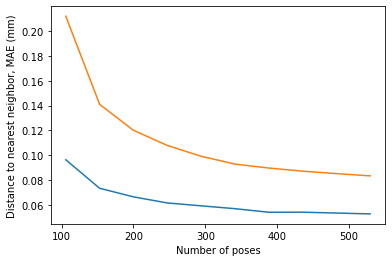

In [52]:
import random 

poses = np.array(poses)
nns_2d = np.array(nns_2d)
nns_3d = np.array(nns_3d)
frac = np.linspace(0.2,1,10)
error2d, error3d = [], []
ind = range(len(poses))
fold = 10
for s in range(fold): #10-fold cross validation
    ind_test = random.sample(ind,int(1/fold*len(ind)))
    diff = set(ind) - set(ind_test)
    
    err2d, err3d = [], []
    for f in frac:
        ind_train = random.sample(diff,int(f*len(diff)))
        
        A_est_2D = best_linear_map(pts2d_source,pts2d_target[poses[ind_train]],nns_2d[ind_train],nn=1)
        A_est_3D = best_linear_map(pts3d_source,pts3d_target[poses[ind_train]],nns_3d[ind_train],nn=1)
        
        pts2d_prism = apply_linear_map(A_est_2D, pts2d_target[poses[ind_test]])
        pts3d_prism = apply_linear_map(A_est_3D, pts3d_target[poses[ind_test]])
        
        err2d.append(np.abs(pts2d_source[nns_2d[ind_test][:,0]] - pts2d_prism).mean())
        err3d.append(np.abs(pts3d_source[nns_3d[ind_test][:,0]] - pts3d_prism).mean())
        
    error2d.append(np.array(err2d))
    error3d.append(np.array(err3d))
    
error2d = np.array(error2d)*2.5/400 #px to mm conversion
error3d = np.array(error3d) #this is already in mm

plt.plot(frac*len(poses)*(1-1/fold), error2d.mean(0))
plt.plot(frac*len(poses)*(1-1/fold), error3d.mean(0))
plt.ylabel('Distance to nearest neighbor, MAE (mm)')
plt.xlabel('Number of poses')
#plt.savefig('cross_validation.svg')

In [53]:
#import pandas
#d = pandas.DataFrame(data=np.vstack([error2d.mean(0),error3d.mean(0)]).T,index=frac*len(poses)*(1-1/fold), columns=['error2d','error3d'])
#d.to_csv('Figure_3C.csv')

# Find best linear transformation for 2D, d2

In [54]:
nn=2

A_est_2D = best_linear_map(pts2d_source, pts2d_target[poses], nns_2d, nn=nn)
pts2d_prism = apply_linear_map(A_est_2D, pts2d_target)


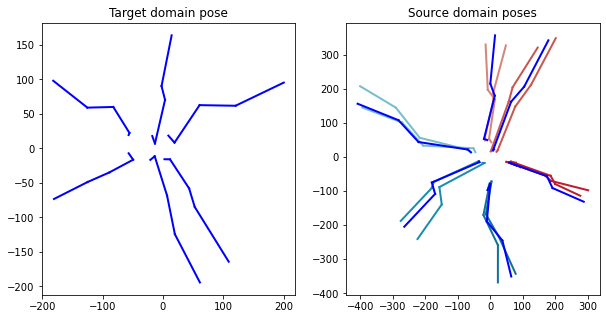

In [55]:
ind = 0

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plot_pose_2d(
    ax, 
    pts2d_target[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)
ax.set_title('Target domain pose')

ax = fig.add_subplot(122)
ax.set_title('Source domain poses')

for i in nns_2d[ind][:nn]:
    plot_pose_2d(
        ax, 
        pts2d_source[i], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
    )
    
plot_pose_2d(
    ax, 
    pts2d_prism[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)
#plt.savefig('2D_mapping.svg')

# Find best linear transformation for 3D, d3

In [56]:
nn = 1

#A_est_3D = best_linear_map(pts3d_source,pts3d_target[poses],nns_3d,nn=nn)#, vis_pts=keypts_target[poses])

A_est_3D = pickle.load(open('prism_to_DF3D_3D.pkl','rb'))
pts3d_prism = apply_linear_map(A_est_3D, pts3d_target)
    

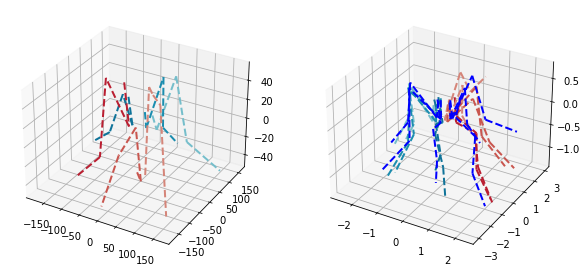

In [57]:
ind = 2
nn=2

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

plot_pose_3d(ax1, 
             par_data["vis"]["bones"], 
             pts3d_target[ind],  
             #tar=,    
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"],
             #good_keypts = keypts_target[ind],
             normalize=False,
             axes=True)

for i in nns_3d[ind][:nn]:
    plot_pose_3d(
        ax2,
        bones=par_data["vis"]["bones"],          
        pred=pts3d_source[i],  
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
        #good_keypts=keypts_target[poses[ind]]
        axes=True
    )   
    
plot_pose_3d(
    ax2,
    bones=par_data["vis"]["bones"], 
    pred=pts3d_prism[poses[ind]],     
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
    #good_keypts=keypts_target[poses[ind]]
    axes=True
)
    
#plt.savefig('3D_mapping.svg')

# Predict poses with trained network

In [61]:
pts2d_prism.shape

(11779, 30, 2)

In [66]:
from liftpose.postprocess import load_test_results
from liftpose.main import set_test_data
from liftpose.main import test as lp3d_test
from liftpose.lifter.utils import filter_data

kp = keypts_target
        
#normalize test data
test_2d, test_3d, stat_2d, stat_3d = set_test_data(par_train['out_dir'], {'':pts2d_prism.copy()}, {'':pts3d_prism.copy()})
    
#test data on network
lp3d_test(par_train['out_dir'],test_2d, test_3d)
    
#load statistics and test results
gt, pred, _ = load_test_results(par_train['out_dir'], stat_2d, stat_3d)

#filter noise
#test_3d_gt = filter_data(test_3d_gt)
#test_3d_pred = filter_data(test_3d_pred)


[main.py:335]:INFO:starting testing in path: /data/LiftPose3D/domain_adaptation
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.33M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/domain_adaptation/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 29 | err: 0.0435903278757361)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/domain_adaptation/test_results.pth.tar


# Errors

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/plot.py:403: RuntimeWarning: Mean of empty slice
  err = np.nanmean(np.abs(gt - pred), axis=-1)
/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/plot.py:405: RuntimeWarning: Mean of empty slice
  err = np.hstack([err, np.nanmean(err, axis=1, keepdims=True)])


(0.0, 0.2)

[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved


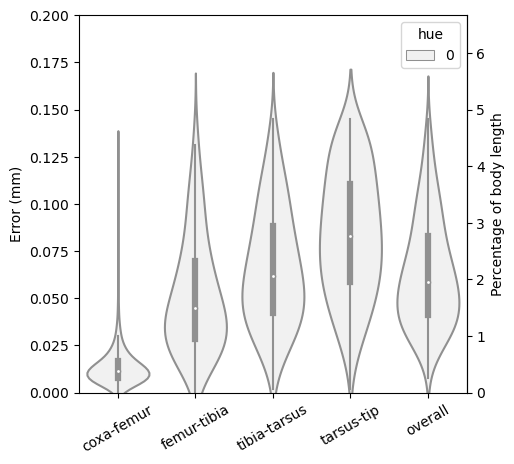

In [68]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(5,5), dpi=100)
names = ['coxa-femur','femur-tibia','tibia-tarsus','tarsus-tip']
ax = plt.gca()
s = gt.shape
gt_reshape = gt.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
pred_reshape = pred.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
kp_reshape = keypts_target.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
violin_plot(ax, gt=gt_reshape, pred=pred_reshape, good_keypts=kp_reshape,
                name=names, order=names, units='mm', body_length=3)
ax.set_ylim([0,0.2])
#plt.savefig('errors.svg')

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


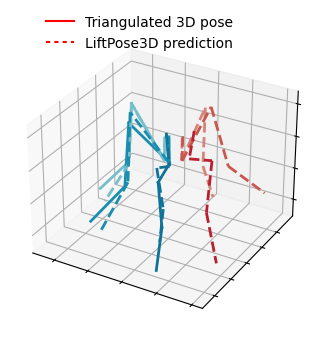

In [26]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

t = 0

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

plot_pose_3d(ax=ax, tar=gt[t], 
            pred=pred[t],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=kp[t],
            show_pred_always=True,
            legend=True)

plt.savefig('pose.svg')

# Video

[animation.py:329]:DEBUG:frame size in pixels is 400 x 400
[animation.py:345]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 400x400 -pix_fmt rgba -r 20 -i pipe: -vcodec h264 -pix_fmt yuv420p -y LiftPose3D_prediction.mp4
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWr

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

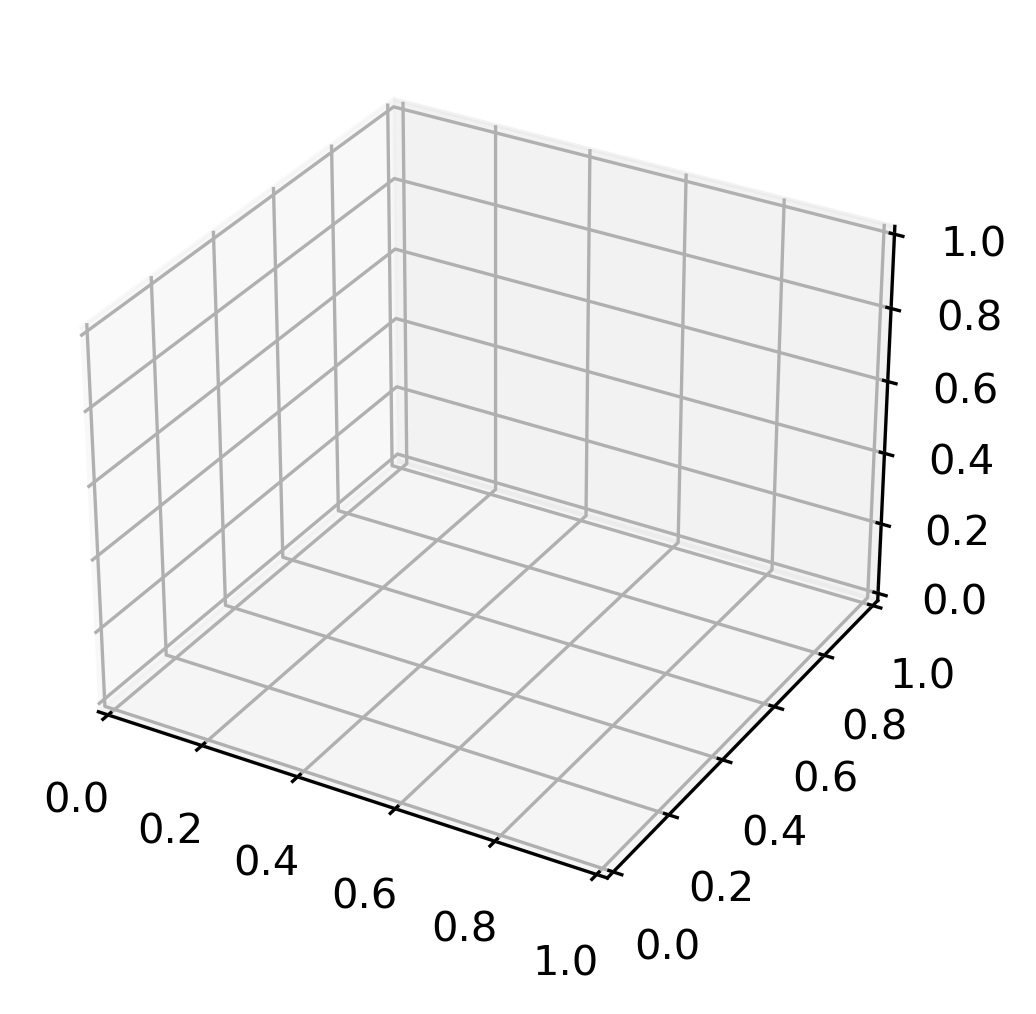

In [41]:
from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=300)
ax = fig.add_subplot(111, projection='3d')

def f(ax, idx):
    ax.cla()

    plot_pose_3d(ax=ax, tar=gt[idx], 
            pred=pred[idx],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=kp[idx],
            show_pred_always=True,
            legend=True)
    
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-1.5,0.5])
    
plot_video_3d(fig, ax, n=500, fps=20, draw_function=f, name='LiftPose3D_prediction.mp4')